In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score


# Import models
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

data_dir = "data/" # Define data path

In [5]:
df = pd.read_csv(data_dir + "food_crises_cleaned.csv") # Read data into DataFrame
df["date"] = pd.to_datetime(df["year_month"], format="%Y_%m") # Create date column
print(len(df['district'].unique()))
df.set_index(["date", "district"], inplace=True) # Set index



78


In [6]:
news_df = pd.read_csv(data_dir + "topic_sentiment.csv") # Read news data into DataFrame

# Create date column
news_df["date"] = pd.to_datetime(
    pd.to_datetime(news_df["date"], format="%Y-%m-%d").dt.strftime("%Y-%m"),
    format="%Y-%m",
)
def create_news_features(columns):
    cols = []
    for column in columns:
        col = news_df.groupby(["date"])[column].mean()
        col = col.fillna(0)
        col = col.rolling(3).mean()
        col = col.shift(3)
        cols.append(col)
    return pd.concat(cols, axis=1)

news_df.drop(['tokens', 'yyyy-mm'], axis=1, inplace=True)
news_features = create_news_features(news_df.columns[5:])
news_features
news_df

,summary,date,location_article,lat,lng,hunger,conflict,humanitarian,refugees,politics,economics,production,land,pests,environment,major,topic,sentiment,difference
0,The article discusses the passing of the new C...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False,False,False,False,False,False,False,False,14,0.991426,0.657156
1,The article discusses the military actions tak...,2011-07-01,Abyei,9.838551,28.486396,False,False,False,False,False,False,False,False,False,False,False,14,-0.997186,0.657156
2,The article discusses the signing of a Framewo...,2011-06-01,Southern Kordofan,11.036544,30.895824,False,False,False,False,False,False,False,False,False,False,False,1,0.982812,0.688175
3,The article discusses the upcoming independenc...,2011-07-01,South Sudan,6.876992,31.306979,False,False,False,False,False,False,False,False,False,False,False,14,0.995117,0.657156
4,The article discusses the need for South Sudan...,2011-07-01,Juba,4.859363,31.571250,False,False,False,False,False,False,False,False,False,False,False,14,0.791571,0.657156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18515,The article discusses the successful delivery ...,2023-04-01,Maiwut Primary Health Care Centre,8.606200,33.924100,False,False,False,False,False,False,False,False,False,False,False,14,0.999743,0.372461
18516,The article discusses the bombing and forced e...,2023-04-01,Khartoum,15.500654,32.559899,False,False,False,False,False,False,False,False,False,False,True,15,-0.865617,-0.921591
18517,The article discusses how Prime Minister Abiy ...,2023-04-01,Addis Ababa,8.980603,38.757761,False,False,False,False,False,False,False,False,False,False,False,1,0.982814,0.342806
18518,The article discusses the collapse of a commer...,2023-04-01,Kampala International University,0.294360,32.603970,False,False,False,False,False,False,False,False,False,False,False,14,-0.990144,0.372461


In [7]:
def create_lag_df(df, columns, lag, difference=False, rolling=None, dropna=False):
    '''
    Function to add lagged colums to dataframe
    
    Inputs:
        df - Dataframe
        columns - List of columns to create lags from
        lag - The number of timesteps (in months for the default data) to lag the variable by
        difference - Whether to take the difference between each observation as new column
        rolling - The size of the rolling mean window, input None type to not use a rolling variable
        dropna - Whether to drop NaN values
        
    Output:
        df - Dataframe with the lagged columns added
    '''
    
    for column in columns:
        col = df[column].unstack()
        if rolling:
            col = col.rolling(rolling).mean()
        if difference:
            col = col.diff()
        if dropna:
            col = col.dropna(how='any')
        df[f"{column}_lag_{lag}"] = col.shift(lag).stack()
    return df

def plot_ConfusionMatrix(prediction, true, binary=False):
    '''
    Function to plot a confusion matrix as a heatmap from a prediction and true values.
    
    Inputs:
        prediction - The predicted values
        true - the true values
        binary - whether the variable is binary or not
        
    Output:
        confusion_matrix - The calculated confusion matrix based on the prediction and true values.
        
        Also plots the confusion matrix as heatmap in an interactive environment such as Jupyter Notebook.
    '''
    
    y_pred = prediction
    
    if not binary:
        # Round prediction to nearest integer (i.e. the nearest phase)
        y_pred = y_pred.round() 
        y_pred = np.minimum(y_pred, 5) # Cap maximum prediction at 5 (maximum phase)
        y_pred = np.maximum(y_pred, 1) # Cap minimum prediction at 1 (minimum phase)

    # Initialize confusion matrix
    confusion_matrix = pd.crosstab(
        true, y_pred, rownames=["Actual"], colnames=["Predicted"]
    )

    # Plot confusion matrix as heatmap
    sns.heatmap(confusion_matrix, annot=True, fmt="g")
    plt.show()
    plt.clf()
    
    return confusion_matrix

In [8]:
df = create_lag_df(df, ['count_violence', 'ndvi_anom'], 3, rolling=6) # 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['food_price_idx'], 3, difference=True, rolling=6) # difference of the 3-month-lagged rolling mean window of size 6
df = create_lag_df(df, ['ipc'], 1, dropna=True) # 1-month-lag
df = create_lag_df(df, ['ipc'], 2, dropna=True) # 2-month-lag
df = create_lag_df(df, ['ipc'], 3, dropna=True) # 3-month-lag

In [9]:
X = df.iloc[:, -24:] # Define explanatory variables
X = sm.add_constant(X) # Add constant column of 1s for intercept
y = df[["ipc"]] # Define target data

In [10]:
combined = (
    pd.DataFrame(y['ipc'])
    .join(news_df.groupby(["date"])["hunger"].mean())
    .join(news_df.groupby(["date"])["conflict"].mean())
    .join(news_df.groupby(["date"])["refugees"].mean())
    .join(news_df.groupby(["date"])["humanitarian"].mean())
    .join(news_df.groupby(["date"])["politics"].mean())
    .join(news_df.groupby(["date"])["economics"].mean())
    .join(news_df.groupby(["date"])["production"].mean())
    .join(news_df.groupby(["date"])["land"].mean())
    .join(news_df.groupby(["date"])["pests"].mean())
    .join(news_df.groupby(["date"])["environment"].mean())
    .join(news_df.groupby(["date"])["major"].mean())
    .join(news_df.groupby(["date"])["difference"].mean())
)


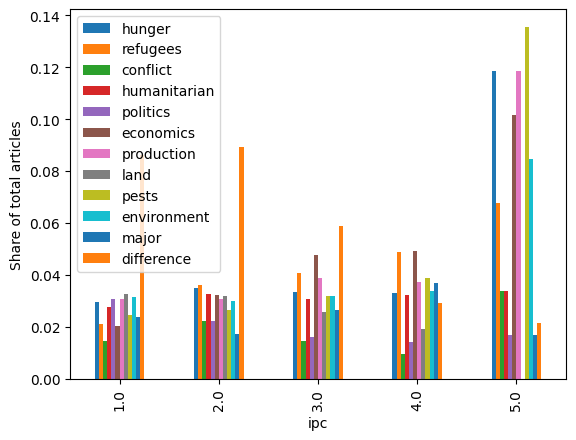

In [11]:
combined.groupby("ipc")[["hunger", "refugees", "conflict", "humanitarian", 
                         "politics", "economics", "production", "land", "pests", 
                         "environment", "major", "difference"]].mean().plot(
    kind="bar", ylabel="Share of total articles"
);

In [12]:
df.sort_index(level=0, inplace=True) # Sort DataFrame by date
df = df.iloc[df['ipc'].notnull().argmax():].copy() # Drop rows until first notna value in ipc column
df = df.join(news_features, how="left") # Join df with created news features

In [13]:
df_copy=df.copy()
df_copy.interpolate(inplace=True)
df_copy.dropna(inplace=True)
df_copy

df_copy["ipc"] = np.clip(np.round(df_copy["ipc"]), 1, 5).astype(int)
df_copy['ipc'].unique()

array([3, 1, 2, 4, 5])

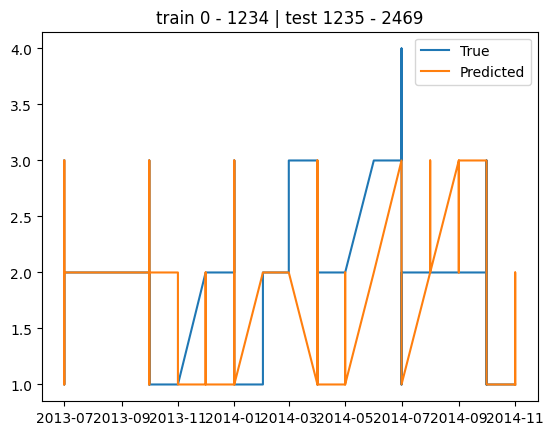

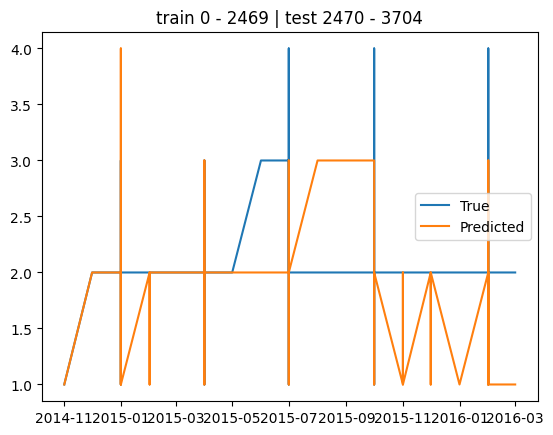

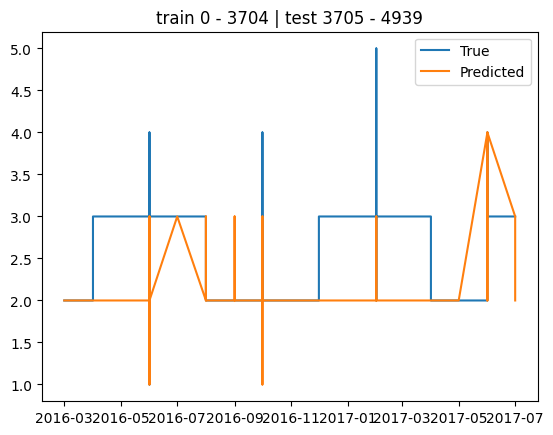

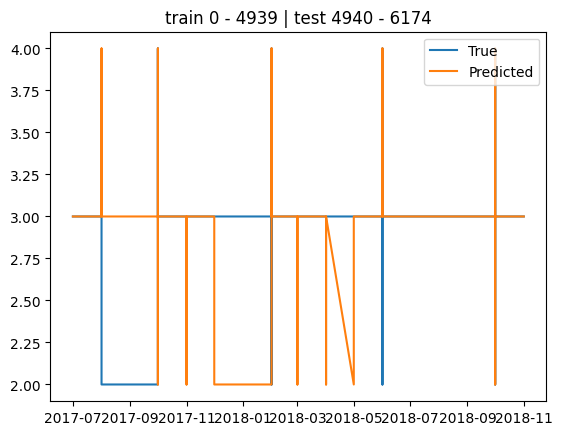

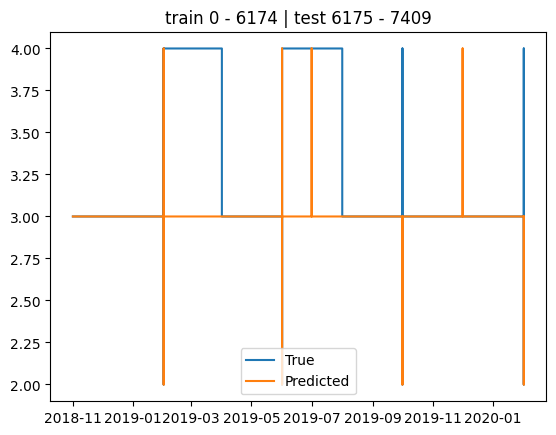

Mean MAE: 0.40
Mean R2: -0.57


In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt

# Assuming dataframe is loaded as df
X = df_copy.iloc[:, -24:]  # Define explanatory variables
y = df_copy[["ipc"]]  # Define target data

cv = TimeSeriesSplit(n_splits=5)  


mae_values = []
r2_values = []

for train_index, val_index in cv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # If X_train doesn't contain any news features, we drop news columns from both X_train and X_test
    X_train = X_train.dropna(axis=1, how='all').copy()
    X_test = X_test[X_train.columns]

    # Interpolate training data to generate more training points
    X_train = X_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    X_train.reset_index(level=0, drop=True, inplace=True)
    y_train = y_train.groupby('district', as_index=False).apply(lambda group: group.interpolate())
    y_train.reset_index(level=0, drop=True, inplace=True)

    # Fill any remaining NaNs after interpolation
    X_train.fillna(X_train.mean(), inplace=True)
    X_test.fillna(X_train.mean(), inplace=True)  # Use the train set mean to fill NaNs in the test set

    # Debugging to check if NaNs still exist
    if X_train.isnull().sum().sum() > 0:
        print("NaNs in X_train:", X_train.isnull().sum())
    if X_test.isnull().sum().sum() > 0:
        print("NaNs in X_test:", X_test.isnull().sum())
    if y_train.isnull().sum().sum() > 0:
        print("NaNs in y_train:", y_train.isnull().sum())

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    y_train = np.clip(np.round(y_train), 1, 5).astype(int)
    model.fit(X_train, y_train.values.ravel())

    y_pred = model.predict(X_test)
    ########## DODAJE TO ZEBY ZAOKRAGLIC
    y_pred_rounded = np.clip(np.round(y_pred), 1, 5).astype(int)

    # Append results to respective lists
    mae_values.append(mean_absolute_error(y_val, y_pred_rounded))
    r2_values.append(r2_score(y_val, y_pred_rounded))

    # Plot
    plt.title(f'train {train_index[0]} - {train_index[-1]} | test {val_index[0]} - {val_index[-1]}')
    time_index = y_val.index.get_level_values(0)
    plt.plot(time_index, y_val, label='True')
    plt.plot(time_index, y_pred_rounded, label='Predicted')
    plt.legend()
    plt.show()

print(f"Mean MAE: {np.mean(mae_values):.2f}") 
print(f"Mean R2: {np.mean(r2_values):.2f}")


In [15]:
y_pred_rounded[:50]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3])

In [16]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

X = df_copy.iloc[:, -24:].dropna(axis=1, how='all')  
y = df_copy[["ipc"]]  # Define target data

cv = TimeSeriesSplit(n_splits=5)  # Define TimeSeriesSplit with 5 splits


mae_values = list()
r2_values = list()

for train_index, val_index in cv.split(X):

    # Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Interpolate and fill NaN values
    X_train = X_train.interpolate().fillna(X_train.mean())
    X_test = X_test.interpolate().fillna(X_train.mean())
    y_train = y_train.interpolate().fillna(y_train.mean())

    # train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
    model.fit(X_train, y_train)

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_rounded = np.clip(np.round(y_pred), 1, 5).astype(int)

    # Calculate and append the metrics
    mae_values.append(mean_absolute_error(y_val, y_pred))
    r2_values.append(r2_score(y_val, y_pred))

# Print the mean metrics
print(f"Mean MAE: {np.mean(mae_values):.2f}") 
print(f"Mean R2: {np.mean(r2_values):.2f}")


Mean MAE: 0.48
Mean R2: -0.56


In [18]:
df_copy_2=df.copy()

df_copy_2.dropna(inplace=True)


df_copy_2['ipc'].unique()


array([3., 1., 2., 4., 5.])

### LSTM

c:\Users\20211445\OneDrive - TU Eindhoven\Desktop\University\Y3Q1\DBL 3\JBG060-DC3\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


39/39 [==============================] - 1s 1ms/step


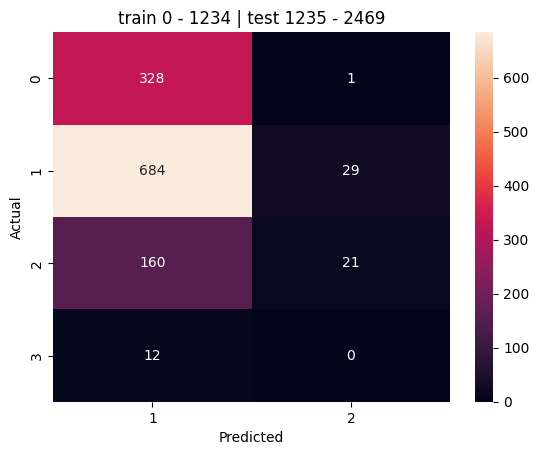

39/39 [==============================] - 1s 3ms/step


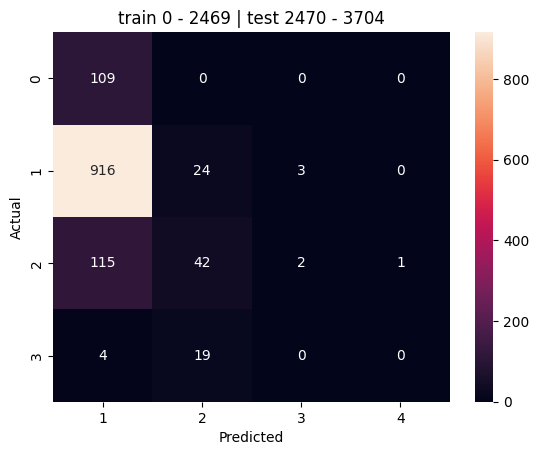

39/39 [==============================] - 1s 2ms/step


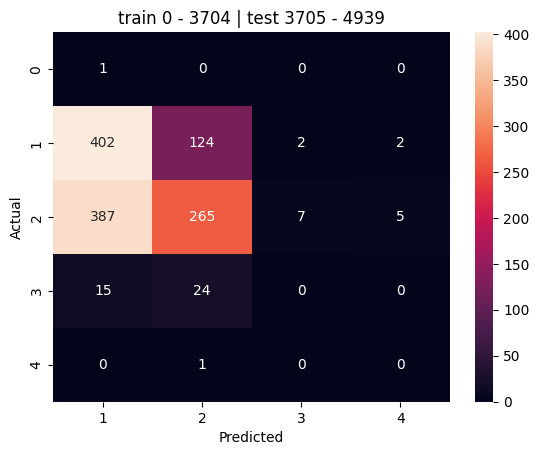

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming dataframe is loaded as df
X = df_copy.iloc[:, -24:].dropna(axis=1, how='all').values  # Explanatory variables
y = df_copy["ipc"].values.reshape(-1,1)  # Target variable

# Round y to nearest integer in [1,5] range
y_rounded = np.clip(np.round(y), 1, 5).astype(int)

# Normalize the data
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

# Convert y_rounded to one-hot encoding
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y_rounded)

cv = TimeSeriesSplit(n_splits=5)

# Initialize empty lists to store scores
mae_values = []
r2_values = []
split_num = 1

for train_index, val_index in cv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    # Reshape the data into 3D array (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0, shuffle=False)

    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    mae_values.append(mean_absolute_error(y_true, y_pred))
    r2_values.append(r2_score(y_true, y_pred))

    # Define internal labels and display labels for the confusion matrix
    # internal_labels = [0,1,2,3,4]
    # display_labels = [1,2,3,4,5]

    # cm = confusion_matrix(y_true, y_pred, labels=internal_labels)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    # disp.plot()
    # plt.title(f'Confusion Matrix for Split {split_num}')
    # plt.show()
    plt.title('train %s - %s | test %s - %s' % (train_index[0], train_index[-1], val_index[0], val_index[-1]))
    plot_ConfusionMatrix(prediction = y_pred, true = y_true) # Plot confusion matrix


    split_num += 1

print(f"Mean MAE: {np.mean(mae_values):.2f}") 
print(f"Mean R2: {np.mean(r2_values):.2f}")


In [ ]:
df3=df.copy()
df3.dropna(inplace=True)
df3

country  district_code     centx     centy  \
date       district                                                       
2012-04-01 Abiemnhom     South Sudan            136  29.13019  9.550939   
           Akobo         South Sudan            114  32.85308  7.799214   
           Anzara        South Sudan             86  28.20598  5.309739   
           Aweil Center  South Sudan            128  26.89562  8.417934   
           Aweil East    South Sudan            141  27.61364  9.243139   
...                              ...            ...       ...       ...   
2020-02-01 Wulu          South Sudan            105  29.20889  6.200243   
           Yambio        South Sudan             82  28.54729  5.124909   
           Yei           South Sudan             81  30.34454  4.252148   
           Yirol East    South Sudan            107  30.80245  6.793194   
           Yirol West    South Sudan            101  30.48698  6.395244   

                        year_month  year  month  ipc   ha  ndvi_mean  ...  \
date       district                                                   ...   
2012-04-01 Abiemnhom       2012_04  2012      4  3.0  0.0   0.268284  ...   
           Akobo           2012_04  2012      4  3.0  1.0   0.235721  ...   
           Anzara          2012_04  2012      4  1.0  0.0   0.593272  ...   
           Aweil Center    2012_04  2012      4  3.0  0.0   0.317193  ...   
           Aweil East      2012_04  2012      4  3.0  0.0   0.235378  ...   
...                            ...   ...    ...  ...  ...        ...  ...   
2020-02-01 Wulu            2020_02  2020      2  2.0  0.0   0.374735  ...   
           Yambio          2020_02  2020      2  3.0  0.0   0.468085  ...   
           Yei             2020_02  2020      2  3.0  0.0   0.452878  ...   
           Yirol East      2020_02  2020      2  4.0  0.0   0.410408  ...   
           Yirol West      2020_02  2020      2  3.0  0.0   0.319411  ...   

                             politics  economics  production      land  \
date       district                                                      
2012-04-01 Abiemnhom     6.556476e-02   0.013545    0.036401  0.015875   
           Akobo         6.556476e-02   0.013545    0.036401  0.015875   
           Anzara        6.556476e-02   0.013545    0.036401  0.015875   
           Aweil Center  6.556476e-02   0.013545    0.036401  0.015875   
           Aweil East    6.556476e-02   0.013545    0.036401  0.015875   
...                               ...        ...         ...       ...   
2020-02-01 Wulu          4.625929e-18   0.056730    0.022052  0.032258   
           Yambio        4.625929e-18   0.056730    0.022052  0.032258   
           Yei           4.625929e-18   0.056730    0.022052  0.032258   
           Yirol East    4.625929e-18   0.056730    0.022052  0.032258   
           Yirol West    4.625929e-18   0.056730    0.022052  0.032258   

                            pests  environment     major      topic  \
date       district                                                   
2012-04-01 Abiemnhom     0.010251     0.024140  0.015592  14.346352   
           Akobo         0.010251     0.024140  0.015592  14.346352   
           Anzara        0.010251     0.024140  0.015592  14.346352   
           Aweil Center  0.010251     0.024140  0.015592  14.346352   
           Aweil East    0.010251     0.024140  0.015592  14.346352   
...                           ...          ...       ...        ...   
2020-02-01 Wulu          0.011494     0.010753  0.022989  10.458727   
           Yambio        0.011494     0.010753  0.022989  10.458727   
           Yei           0.011494     0.010753  0.022989  10.458727   
           Yirol East    0.011494     0.010753  0.022989  10.458727   
           Yirol West    0.011494     0.010753  0.022989  10.458727   

                         sentiment  difference  
date       district                             
2012-04-01 Abiemnhom     -0.007164   -0.007164  
           Akobo 

c:\Users\20211445\OneDrive - TU Eindhoven\Desktop\University\Y3Q1\DBL 3\JBG060-DC3\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


12/12 [==============================] - 1s 2ms/step


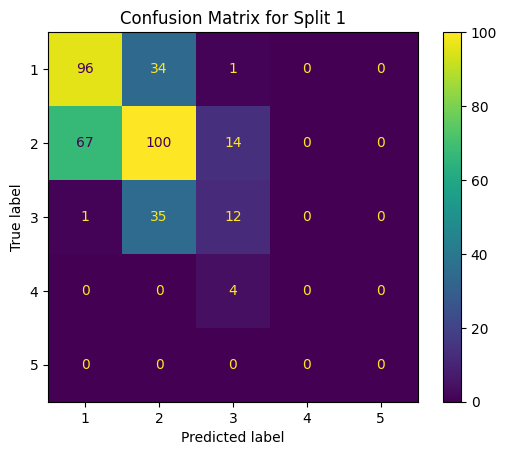

12/12 [==============================] - 1s 2ms/step


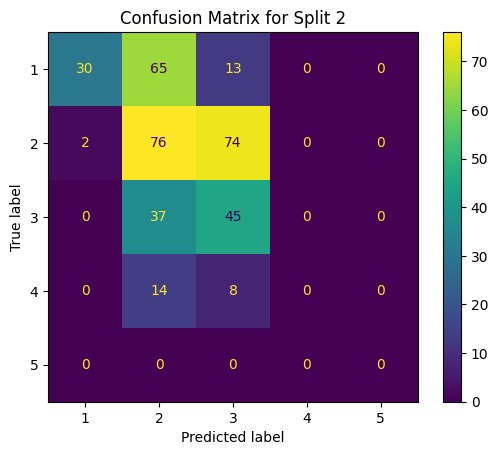

12/12 [==============================] - 1s 2ms/step


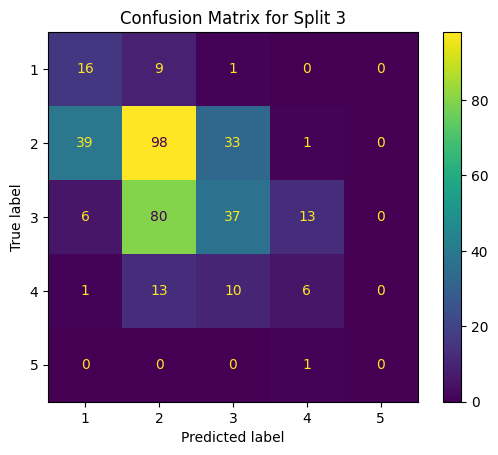

12/12 [==============================] - 1s 2ms/step


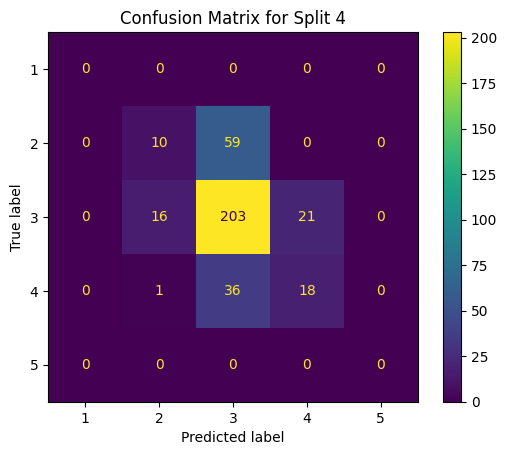

12/12 [==============================] - 1s 2ms/step


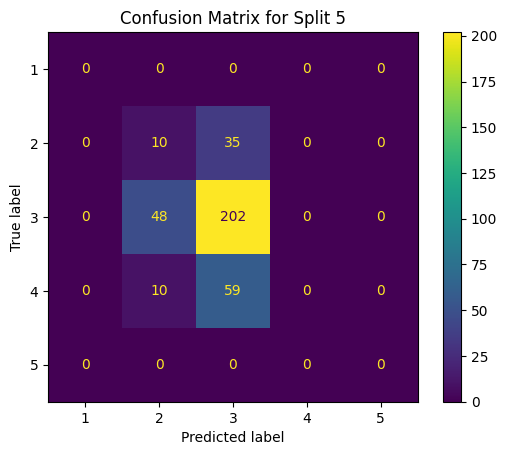

Mean MAE: 0.51
Mean R2: -0.20


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming dataframe is loaded as df
X = df3.iloc[:, -24:].dropna(axis=1, how='all').values  # Explanatory variables
y = df3["ipc"].values.reshape(-1,1)  # Target variable

# Round y to nearest integer in [1,5] range
y_rounded = np.clip(np.round(y), 1, 5).astype(int)

# Normalize the data
scaler_X = MinMaxScaler()
X = scaler_X.fit_transform(X)

# Convert y_rounded to one-hot encoding
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y_rounded)

cv = TimeSeriesSplit(n_splits=5)

# Initialize empty lists to store scores
mae_values = []
r2_values = []
split_num = 1

for train_index, val_index in cv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_encoded[train_index], y_encoded[val_index]

    # Reshape the data into 3D array (samples, timesteps, features)
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

    # Build LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dense(5, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0, shuffle=False)

    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    mae_values.append(mean_absolute_error(y_true, y_pred))
    r2_values.append(r2_score(y_true, y_pred))

    # Define internal labels and display labels for the confusion matrix
    internal_labels = [0,1,2,3,4]
    display_labels = [1,2,3,4,5]

    cm = confusion_matrix(y_true, y_pred, labels=internal_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot()
    plt.title(f'Confusion Matrix for Split {split_num}')
    plt.show()


    split_num += 1

print(f"Mean MAE: {np.mean(mae_values):.2f}") 
print(f"Mean R2: {np.mean(r2_values):.2f}")
